In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/CS329R/329RFinalProjectScripts/merged_file_sample=100k_section=dischargeinstructions.csv", sep=";")
data.head()

,subject_id,race,gender,note_id,hadm_id,note_type,note_seq,charttime,storetime,text
0,16296993,HISPANIC OR LATINO,F,16296993-DS-15,29822735,DS,15,2182-01-26 00:00:00,2182-01-26 16:07:00,admitted hospital asthma exacerbation received...
1,11946106,WHITE,M,11946106-DS-15,28989986,DS,15,2145-04-15 00:00:00,2145-04-15 15:24:00,discharge instructions surgery you underwent ...
2,15434830,WHITE,F,15434830-DS-26,23810915,DS,26,2133-08-10 00:00:00,2133-08-14 09:00:00,dear miss pleasure taking care admitted treate...
3,16341189,WHITE,F,16341189-DS-18,29601467,DS,18,2157-06-18 00:00:00,2157-06-18 17:41:00,dear ms pleasure involved care admitted admitt...
4,12689971,WHITE,M,12689971-DS-7,29090388,DS,7,2148-06-06 00:00:00,2148-06-06 11:02:00,steps help recover procedure do drink plenty ...


In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import pandas as pd
from gensim.models import Word2Vec
from collections import Counter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Download required NLTK data files
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# Function to extract section content
def extract_section(pattern, text):
    match = re.search(pattern, text)
    if match:
        return match.group(1).strip()
    else:
        return ""

def clean_text(text):
    # Tokenize text into words
    print(text)
    tokens = nltk.word_tokenize(text)

    # Convert tokens to lowercase + remove x95
    tokens = [re.sub(r'\x95',"",token.lower()) for token in tokens if token != '\x95']

    # Remove punctuation
    tokens = [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Filter out tokens that contain numbers
    tokens = [token for token in tokens if not any(char.isdigit() for char in token)]

    tokens = lambda x: re.sub(r'\x95',"",x)

    # # Apply stemming (optional)
    # stemmer = PorterStemmer()
    # tokens = [stemmer.stem(token) for token in tokens]

    # Remove empty tokens
    tokens = [token for token in tokens if token]

    return tokens

def seperate(text):
  if not isinstance(text, str):
    return []
  return text.split()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['OTHER' 'ASIAN']
['OTHER' 'ASIAN']
OTHER
['admitted', 'hospital', 'asthma', 'exacerbation', 'received', 'prednisone', 'inhalers', 'good', 'effect', 'still', 'need', 'time', 'recover', 'also', 'restarted', 'home', 'cardiac', 'medications', 'weigh', 'every', 'morning', 'call', 'md', 'weight', 'goes', 'lbs', 'please', 'see', 'also']
97804


<ipython-input-10-24a3ed643593>:49: UserWarning: Glyph 149 (\x95) missing from current font.
  plt.savefig(f'{r}.png')


ASIAN
['dear', 'ms', 'pleasure', 'taking', 'care', 'came', 'us', 'initially', 'experiencing', 'difficulty', 'breathing', 'sharp', 'chest', 'pressure', 'received', 'imaging', 'chest', 'demonstrate', 'clot', 'however', 'show', 'fluid', 'right', 'lung', 'pleural', 'effusion', 'asked', 'interventional', 'pulmonary', 'doctors']
2196


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 149 (\x95) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


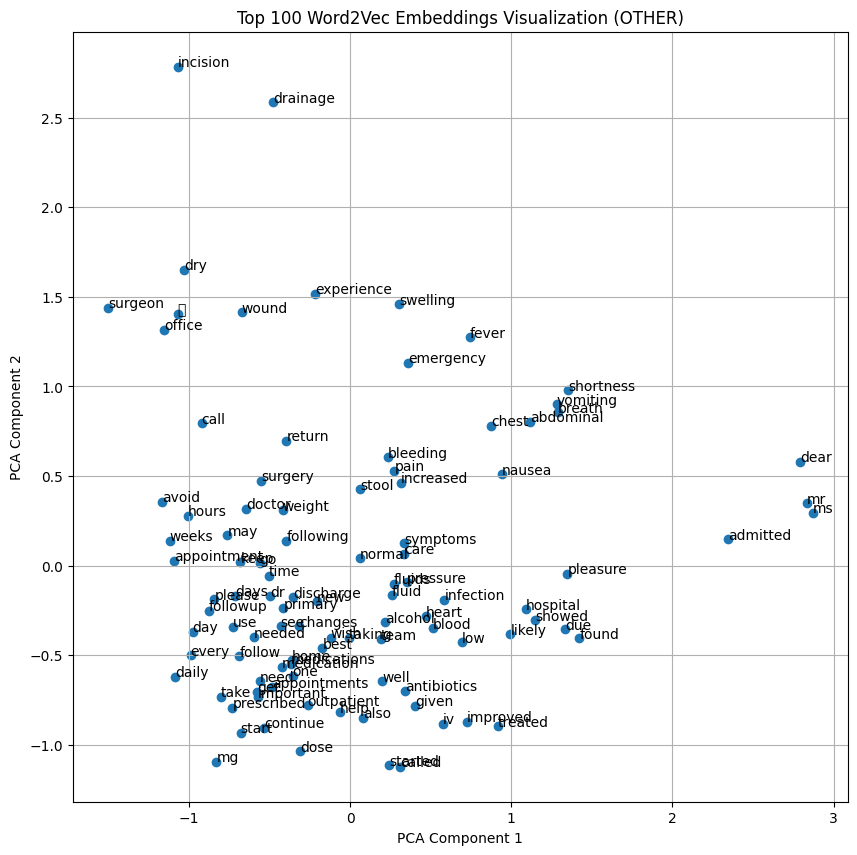

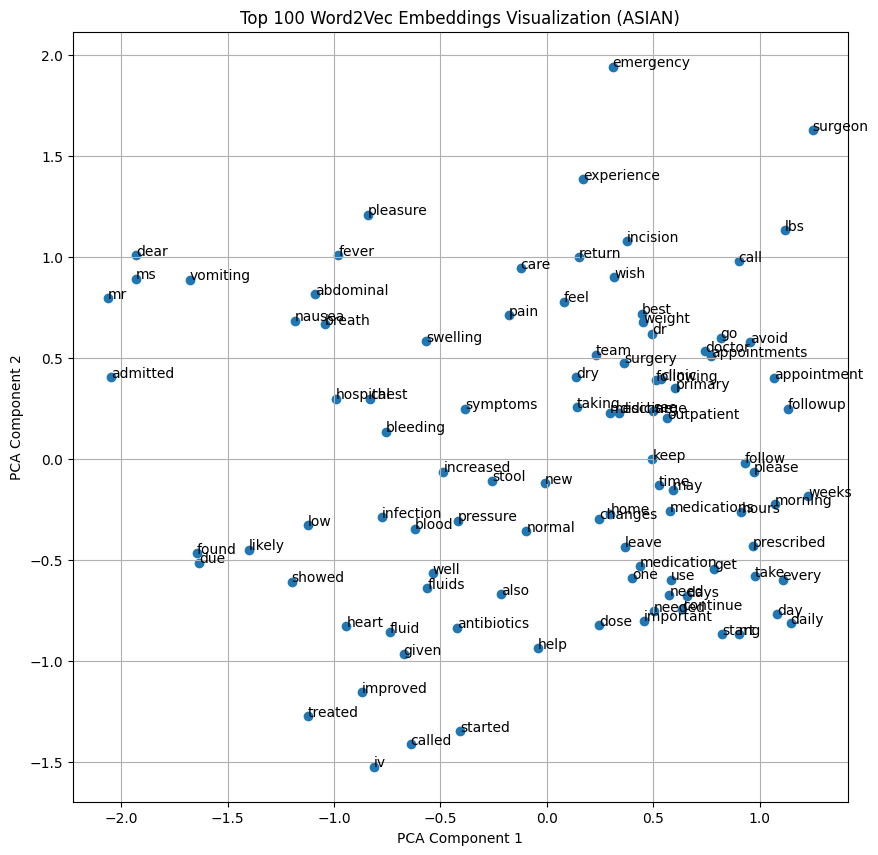

In [10]:
# Train Word2Vec model
old_data = data
# Define a function to simplify race categories
def simplify_race(race):
    race_upper = race.upper()
    if "WHITE" in race_upper:
        return "WHITE"
    elif "BLACK" in race_upper:
        return "BLACK"
    elif "HISPANIC" in race_upper:
        return "HISPANIC"
    elif "ASIAN" in race_upper:
        return "ASIAN"
    else:
        return "OTHER"

# Apply the function to the 'race' column
data['race'] = old_data['race'].apply(simplify_race)
for r in data['race'].unique():
  print(r)
  print(len(data[data['race'] == r]))
for r in data['race'].unique():
  print(r)
  sentences = data[data['race'] == r]['text'].apply(seperate).tolist()
  print(sentences[0][:30])
  print(len(sentences))
  try:
    model = Word2Vec.load(f'{r}.wordvectors')
  except:
    model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, sg=1, workers=4)
    model.save(f'{r}.wordvectors')

  # Count the frequency of words and get the top 100 most common
  word_counts = Counter(word for sentence in sentences for word in sentence)
  top_100_words = [word for word, _ in word_counts.most_common(100)]

  # Extract embeddings for the top 100 words
  embeddings = [model.wv[word] for word in top_100_words]

  # Reduce dimensionality for visualization using PCA
  pca = PCA(n_components=2)
  reduced_embeddings = pca.fit_transform(embeddings)

  # Plotting the word embeddings
  plt.figure(figsize=(10, 10))
  plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])

  for i, word in enumerate(top_100_words):
      plt.annotate(word, xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

  plt.title(f'Top 100 Word2Vec Embeddings Visualization ({r})')
  plt.xlabel('PCA Component 1')
  plt.ylabel('PCA Component 2')
  plt.grid()
  plt.savefig(f'{r}.png')

['admitted', 'hospital', 'asthma', 'exacerbation', 'received', 'prednisone', 'inhalers', 'good', 'effect', 'still', 'need', 'time', 'recover', 'also', 'restarted', 'home', 'cardiac', 'medications', 'weigh', 'every', 'morning', 'call', 'md', 'weight', 'goes', 'lbs', 'please', 'see', 'also']


<ipython-input-35-c804798ca7e9>:31: UserWarning: Glyph 149 (\x95) missing from current font.
  plt.savefig('pca_100k.png')
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 149 (\x95) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


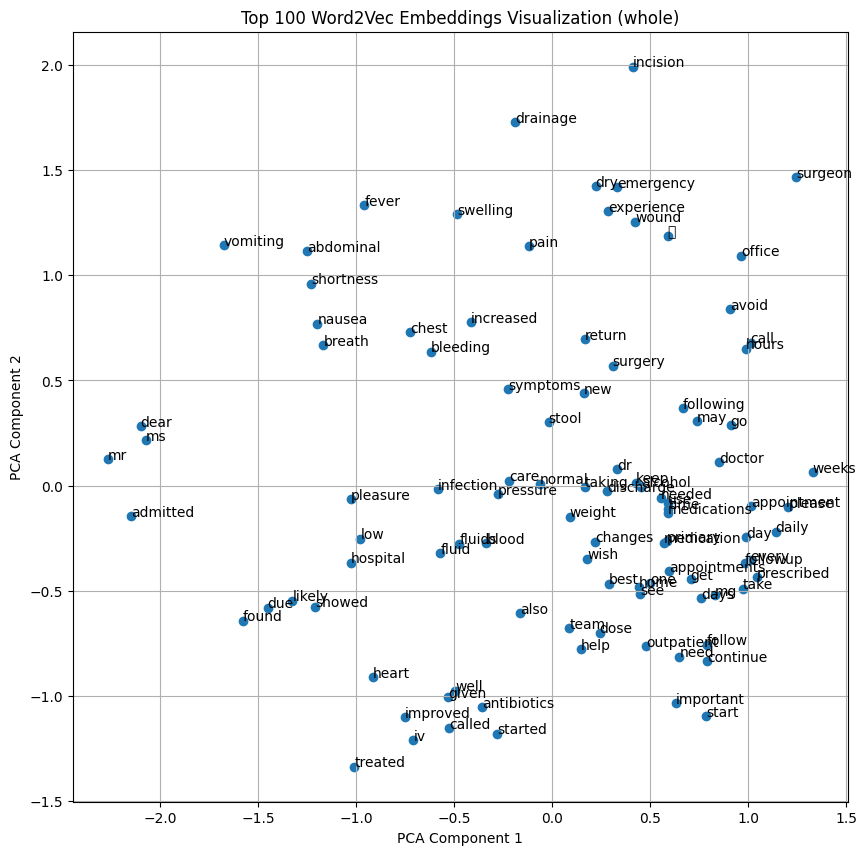

In [ ]:
sentences = data['text'].apply(seperate).tolist()
print(sentences[0])
try:
  model = Word2Vec.load(f'{r}.wordvectors')
except:
  model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, sg=1, workers=4)
  model.save(f'{r}.wordvectors')

# Count the frequency of words and get the top 100 most common
word_counts = Counter(word for sentence in sentences for word in sentence)
top_100_words = [word for word, _ in word_counts.most_common(100)]

# Extract embeddings for the top 100 words
embeddings = [model.wv[word] for word in top_100_words]

# Reduce dimensionality for visualization using PCA
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Plotting the word embeddings
plt.figure(figsize=(10, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])

for i, word in enumerate(top_100_words):
    plt.annotate(word, xy=(reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.title('Top 100 Word2Vec Embeddings Visualization (whole)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid()
plt.savefig('pca_100k.png')